# Feature learning vs random features

In this  tutorial, we will see how a one-hidden layer network can exhibit different learning regimes depending on the intialization:  
- A random feature regime, where the network behaves like a kernel method with nearly random features.
- A feature learning regime, where the hidden layer learns 'better' features that are well adapted to the data.


We will start by performing a ridgless regression on toy data using features provided by a one-hidden layer network. 
The network is specifically chosen to have a large number of neurons (much larger than training points), so that training data a fitted perfectly. 

Then we will train the whole network on the training data starting from different initializations for the network parameters and compare the generalization performance to that of the ridgless regression with random initialization.



In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt




In [36]:
def set_seeds(seed):    

    import torch
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    import numpy as np
    import random
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)


In [53]:
# Define student network (1 hidden layer, 1000 neurons)
class OneHiddenLayer(nn.Module):
    def __init__(self, dim_in=10, num_hidden=1000,init_std=1., zero_init=True):
        super().__init__()
        self.features  = nn.Sequential( nn.Linear(dim_in, num_hidden,bias=False), torch.nn.ReLU())
        self.features[0].weight.data.normal_(0, init_std)
        self.linear = nn.Linear(num_hidden, 1, bias=False)
        if zero_init:
            self.linear.weight.data.zero_()
        self.normalizing_factor=num_hidden
    
    def forward(self, x):
        x = self.features(x)
        return self.linear(x)/self.normalizing_factor

def squared_loss(a,b):
            return 0.5*torch.mean((a-b)**2)
    
    
# Generate high-dimensional Gaussian input
set_seeds(0)
N_train = 100
X_train = np.random.randn(N_train, 10)
X_test = np.random.randn(1000, 10)
X_train = torch.tensor(X_train, dtype=torch.float64)
X_test = torch.tensor(X_test, dtype=torch.float64)


# Define teacher network (1 hidden layer, 5 neurons).
teacher = OneHiddenLayer(dim_in=10, num_hidden=5,zero_init=False,init_std=1.).double()


# Generate targets from teacher network
y_train = teacher(X_train).detach()
y_test = teacher(X_test).detach()


# Step 1: Kernel regression with fixed hidden layer

In [54]:



def fit_and_predict(model):
    # Takes a input an instance of the class OneHiddenLayer and performs a ridgless regression 
    # from the hidden features of the network. 
    

    H_train = model.features(X_train).detach()
    H_test = model.features(X_test).detach()
    
    
    # Solve linear regression
    W = torch.linalg.lstsq(H_train, y_train).solution
    y_test_pred_kernel = H_test @ W
    y_train_pred_kernel = H_train @ W

    test_error_kernel = squared_loss(y_test_pred_kernel,y_test) 
    train_error_kernel = squared_loss(y_train_pred_kernel,y_train)
    return train_error_kernel, test_error_kernel

student_fixed = OneHiddenLayer(dim_in=10, num_hidden=1000, init_std=1.0).double()
train_error_random_features, test_error_random_features = fit_and_predict(student_fixed) 

print("Train error {}, Test error {}".format(train_error_random_features, test_error_random_features))

Train error 1.2109580167903696e-32, Test error 0.00025212910634384256


In [55]:
# Effect of the number of features on training and test errors

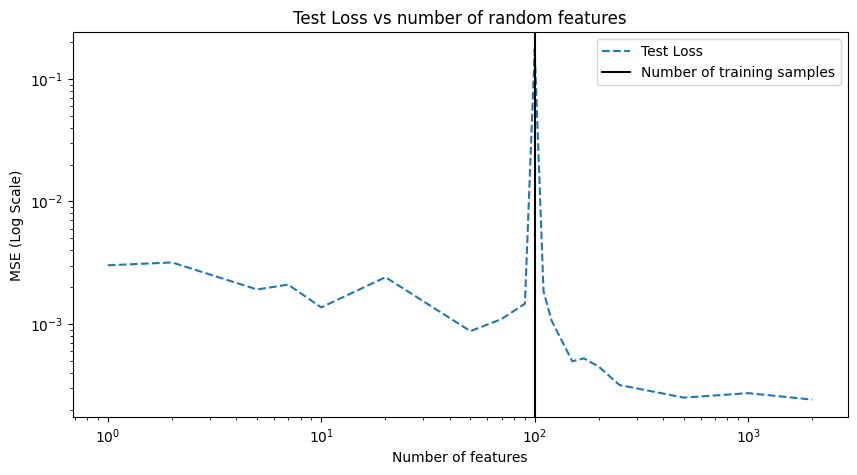

In [57]:
num_hidden_list = [1,2,5,7,10,20,50,70,90,100,110,120,150,170,200,250,500,1000,2000]

train_errors = []*len(num_hidden_list)
test_errors = []*len(num_hidden_list)


for num_hidden in num_hidden_list:
    model = OneHiddenLayer(dim_in=10, num_hidden=num_hidden, init_std=1.0).double()
    train_err, test_err = fit_and_predict(model)
    train_errors.append(train_err)
    test_errors.append(test_err)
    
    

plt.figure(figsize=(10, 5))
#plt.semilogy(num_hidden_list,train_errors, label='Training loss')
plt.loglog(num_hidden_list,test_errors, label='Test Loss', linestyle='dashed')
plt.axvline(x=N_train, color='k', linestyle='-', label='Number of training samples')

plt.xlabel('Number of features')
plt.ylabel('MSE (Log Scale)')
plt.legend()
plt.title('Test Loss vs number of random features')
plt.show()






The test error exhibits a double descent phenomenon: at first test error has a U shape when the number of features are smaller than training size. Then when the model becomes over-parameterized, the error starts decreasing again as the model becomes bigger. 

# Step 2: Training the model using gradient descent

In [45]:
def training_loop(model,lr, num_iters=20000):
    # takes a model, an initial learning rate and a number of iterations, then performs a training loop
    
    
    optimizer = optim.SGD(model.parameters(), lr=lr)
    test_errors = []
    train_errors = []
    for iters in range(num_iters):
        with torch.no_grad():

            test_pred = model(X_test)
            train_pred = model(X_train)
            test_errors.append(squared_loss(test_pred, y_test).item())
            train_errors.append(squared_loss(train_pred, y_train).item())
        optimizer.zero_grad()
        output =model(X_train)
        loss = squared_loss(output, y_train)
        loss.backward()
        optimizer.step()
    return train_errors, test_errors



## 1- Training a network starting from a large initialization

In [46]:

large_init_std  = 100.
lr = 10./large_init_std
model_large_std = OneHiddenLayer(dim_in=10, num_hidden=1000, init_std=large_init_std).double()
train_errors_large, test_errors_large = training_loop(model_large_std,lr=lr,num_iters=20000) ## Can reduce number of iterations to 1000 to debug
train_error_opt_features_large, test_error_opt_features_large = fit_and_predict(model_large_std) 


Train error (initial features) 2.900247524004963e-32, Test error (initial features) 0.000252129106343843
Train error (optimized features)  2.5006379736911386e-32, Test error (optimized features) 0.00023394426752249193


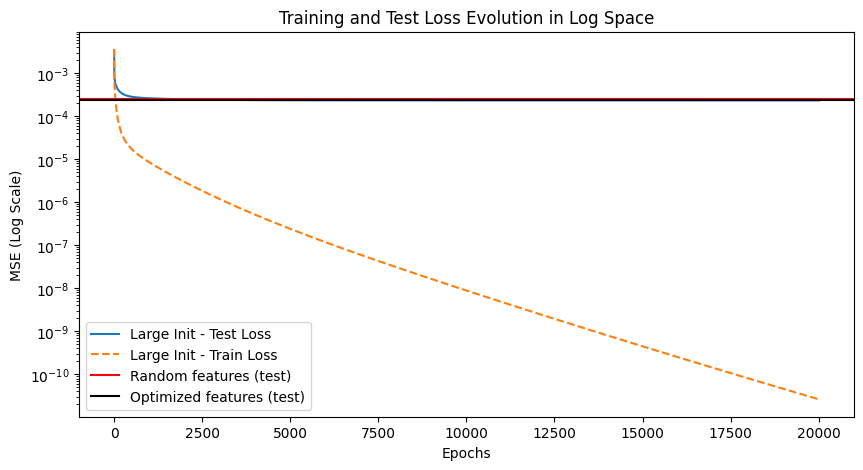

In [47]:
print("Train error (initial features) {}, Test error (initial features) {}".format(train_error_random_features, test_error_random_features))
print("Train error (optimized features)  {}, Test error (optimized features) {}".format(train_error_opt_features_large, test_error_opt_features_large))

# Plot training and test losses in log space
plt.figure(figsize=(10, 5))
plt.semilogy(test_errors_large, label='Large Init - Test Loss')
plt.semilogy(train_errors_large, label='Large Init - Train Loss', linestyle='dashed')
plt.axhline(y=test_error_random_features, color='r', linestyle='-', label='Random features (test)')
plt.axhline(y=test_error_opt_features_large, color='k', linestyle='-', label='Optimized features (test)')
plt.xlabel('Epochs')
plt.ylabel('MSE (Log Scale)')
plt.legend()
plt.title('Training and Test Loss Evolution in Log Space')
plt.show()


In [58]:
## 2- Training a network starting from a small initialization

In [48]:
small_init_std  = 0.1
lr = 10./small_init_std
model_small_std = OneHiddenLayer(dim_in=10, num_hidden=1000, init_std=small_init_std).double()
train_errors_small, test_errors_small = training_loop(model_small_std, lr=lr,num_iters=20000)
train_error_opt_features_small, test_error_opt_features_small = fit_and_predict(model_small_std) 


Train error (initial features) 2.900247524004963e-32, Test error (initial features) 0.000252129106343843
Train error (optimized features)  3.468185644406899e-33, Test error (optimized features) 6.995830615519658e-05


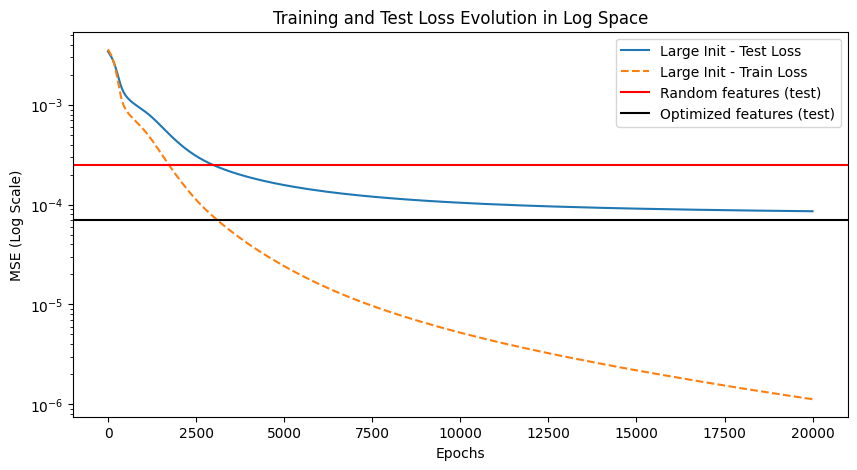

In [49]:
print("Train error (initial features) {}, Test error (initial features) {}".format(train_error_random_features, test_error_random_features))
print("Train error (optimized features)  {}, Test error (optimized features) {}".format(train_error_opt_features_small, test_error_opt_features_small))

# Plot training and test losses in log space
plt.figure(figsize=(10, 5))
plt.semilogy(test_errors_small, label='Large Init - Test Loss')
plt.semilogy(train_errors_small, label='Large Init - Train Loss', linestyle='dashed')
plt.axhline(y=test_error_random_features, color='r', linestyle='-', label='Random features (test)')
plt.axhline(y=test_error_opt_features_small, color='k', linestyle='-', label='Optimized features (test)')
plt.xlabel('Epochs')
plt.ylabel('MSE (Log Scale)')
plt.legend()
plt.title('Training and Test Loss Evolution in Log Space')
plt.show()
